In [1]:
%matplotlib inline

import numpy as np
import hyperspy.api as hs
import pyxem as pxm
import matplotlib.pyplot as plt

# We import a dataset which includes the background matrix

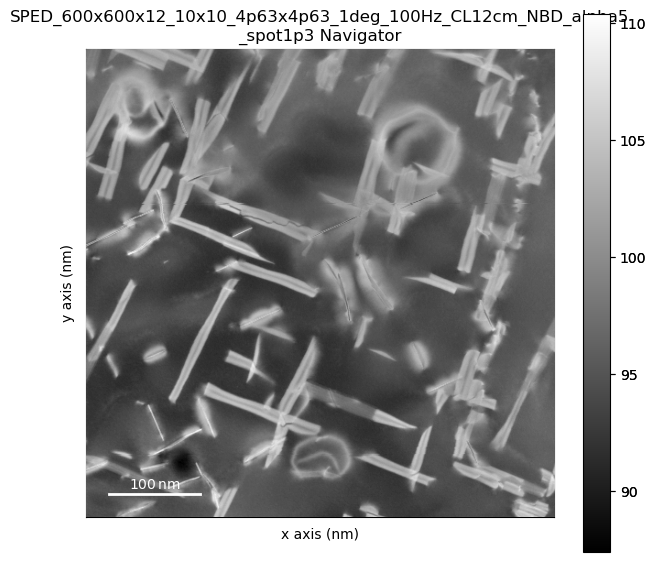

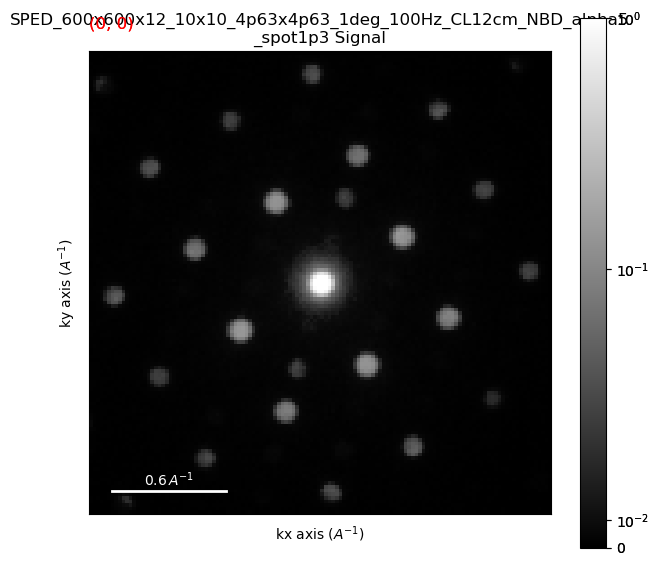

In [2]:
file = r'SPED_600x600x12_10x10_4p63x4p63_1deg_100Hz_CL12cm_NBD_alpha5_spot1p3_preprocessed.hspy'

s = hs.load(file)
s.set_scan_calibration(1)   # Easier to work with scan calibration set to pixels
s.plot(norm='symlog')       # Plot with symlog norm to better see reflections. Press l when in DP to plot in log norm for even better contrast, though this can be buggy...

# If you already made a mask, load it and skip to DoG and applying of mask

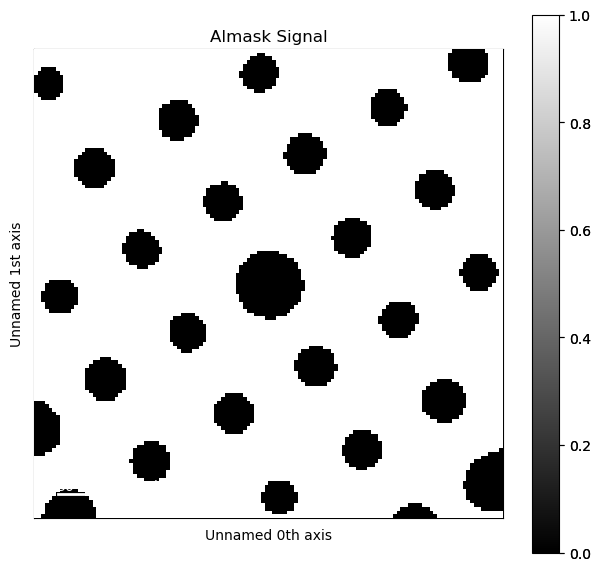

In [3]:
try: 
    tot_mask = hs.load('Almask.hdf5')
    tot_mask.plot()
except:
    print("This file does nos exist, run full script.")

# Creating a mask for matrix and direct spot:

### Crop out to only include Al DP

In [4]:
roi = hs.roi.RectangularROI(left=50, top=25, right=86, bottom=58) # move box to Al region before continuing
roi.add_widget(s)

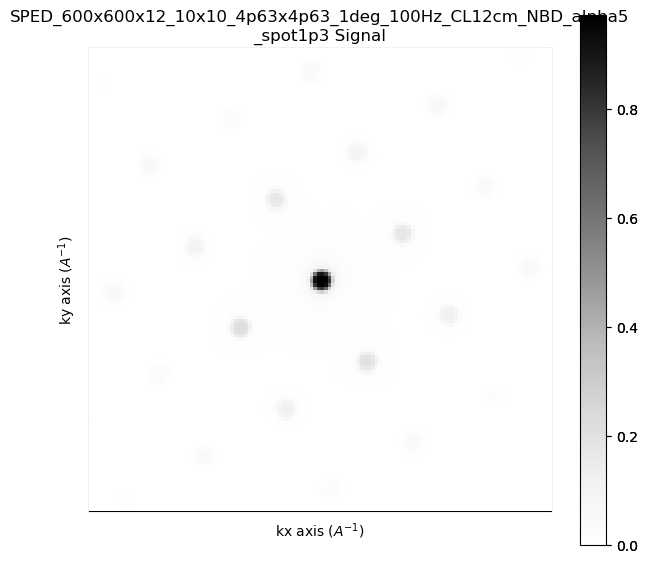

In [5]:
matrix_DP = s.inav[roi[0]:roi[1],roi[2]:roi[3]].mean() # Use roi area from plot before. (Inav use pixels)
matrix_DP.plot(cmap='Greys')

### Do DoG background removal to create an Al mask

#### Can do this Interactively to investigate good parameters first:

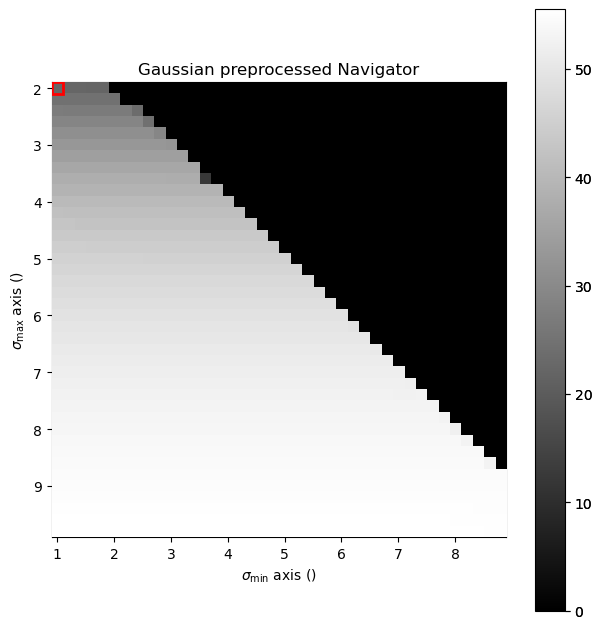

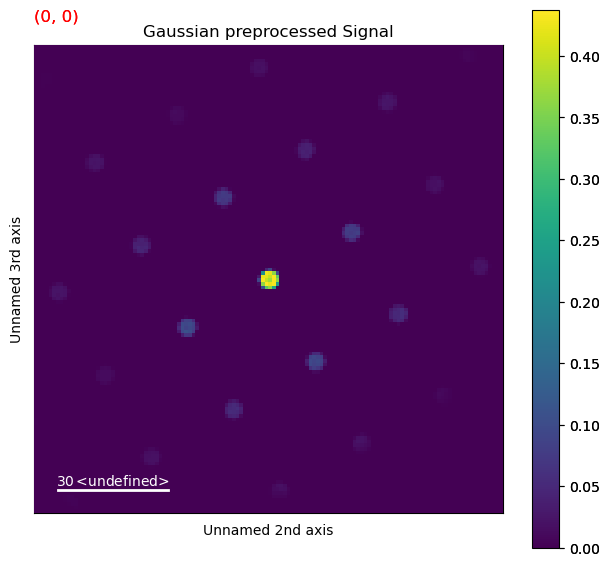

In [6]:
if (True): # Can interactively check which values to use:
    from pyxem.utils.expt_utils import investigate_dog_background_removal_interactive

    gauss_stddev_maxs = np.arange(2, 10, 0.2) # min, max, step
    gauss_stddev_mins = np.arange(1, 9, 0.2) # min, max, step

    investigate_dog_background_removal_interactive(matrix_DP,
                                                gauss_stddev_maxs,
                                                gauss_stddev_mins)

#### When good parameters are found, run it on our mean DP and normalize the result:

[########################################] | 100% Completed |  0.1s


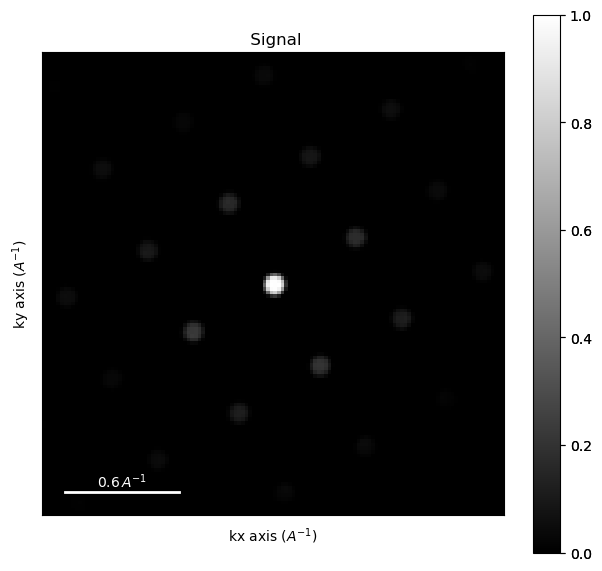

In [7]:
matrix_DP_clean = matrix_DP.subtract_diffraction_background('difference of gaussians',
                                                        min_sigma=3.6, 
                                                        max_sigma=6.4,
                                                        lazy_result=False)
matrix_DP_clean.data *= 1 / matrix_DP_clean.data.max() # Normalize dataset again after this
matrix_DP_clean.plot()

### Set reflections to 1

In [8]:
mask = matrix_DP_clean > 0          # This is for Al DP
mask_central_beam = matrix_DP > 0.2 # This is for central beam, should be larger

### Smooth the spots to make them larger and more circular

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


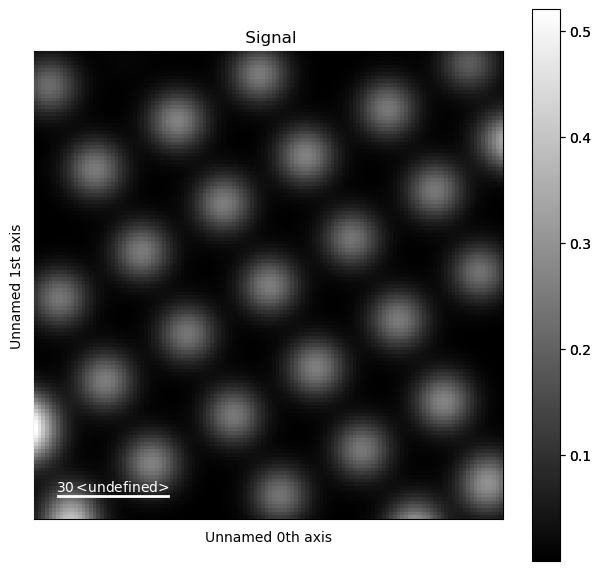

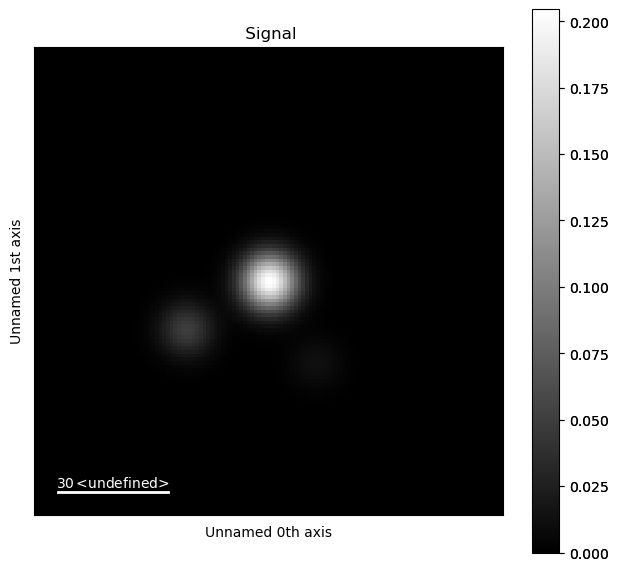

In [9]:
# Here we could use dilation to enlarge the reflections, 
# but they are not very circular so this method seems better:
from skimage import filters

mask_signal = hs.signals.BaseSignal(mask) # We need to make our mask a BaseSignal to be able to map our function on it
mask_smooth = mask_signal.map(filters.gaussian, sigma=5, inplace=False)
mask_smooth.plot()

mask_central_beam_signal = hs.signals.BaseSignal(mask_central_beam)
mask_central_beam_smooth = mask_central_beam_signal.map(filters.gaussian, sigma=5, inplace=False)
mask_central_beam_smooth.plot()

### Set everything below a threshold to 1 in the masks and create a total mask from the inverse of these

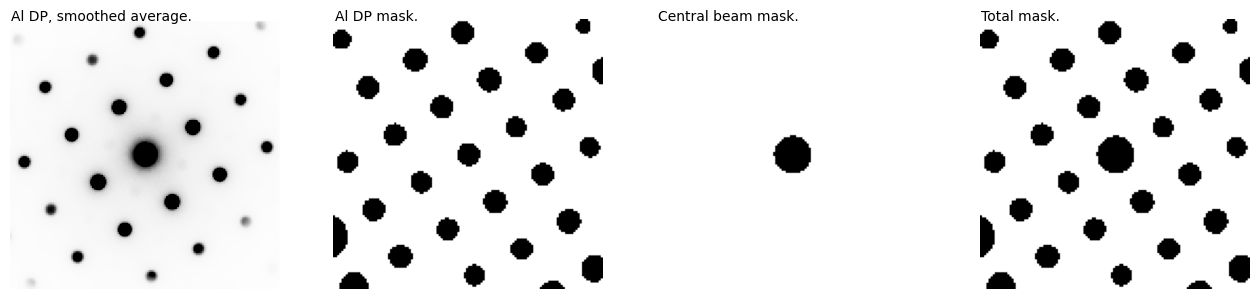

In [10]:
mask = mask_smooth < 0.15                           # if mask_smooth[i,j] is smaller than this, mask[i,j] = 1
mask_central_beam = mask_central_beam_smooth < 0.05

tot_mask = ~mask.data + ~mask_central_beam.data     # ~something returns the inverse of something. This must be done to not only be left with a small central beam mask
tot_mask = hs.signals.BaseSignal(~tot_mask)         # And finally we go back to BaseSignal and invert back so that what is outside Al reflections are kept and inside removed.

fig, ax =plt.subplots(ncols=4, figsize=(16,4))
ax[0].imshow(matrix_DP, cmap='Greys',vmax=0.03)
ax[0].text(0, 0, 'Al DP, smoothed average.')

ax[1].imshow(mask,cmap='Greys_r')
ax[1].text(0, 0, 'Al DP mask.')

ax[2].imshow(mask_central_beam, cmap='Greys_r')
ax[2].text(0, 0, 'Central beam mask.')

ax[3].imshow(tot_mask,cmap='Greys_r')
ax[3].text(0, 0, 'Total mask.')
for i in range(4):
    ax[i].axis('off')

# Do DoG background removal

[########################################] | 100% Completed |  2min  6.2s


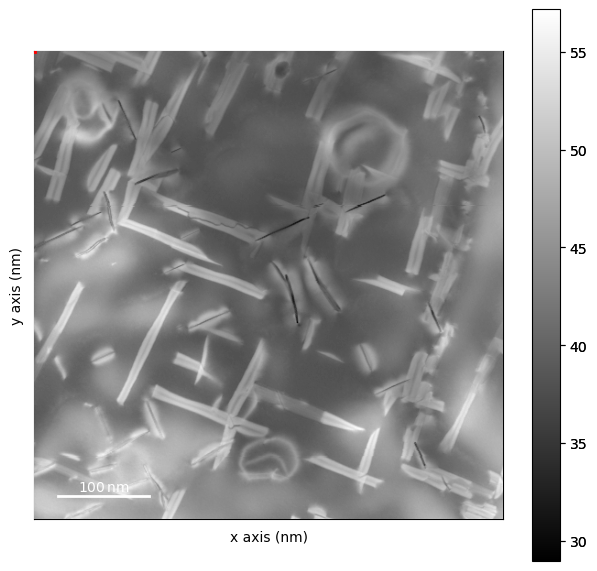

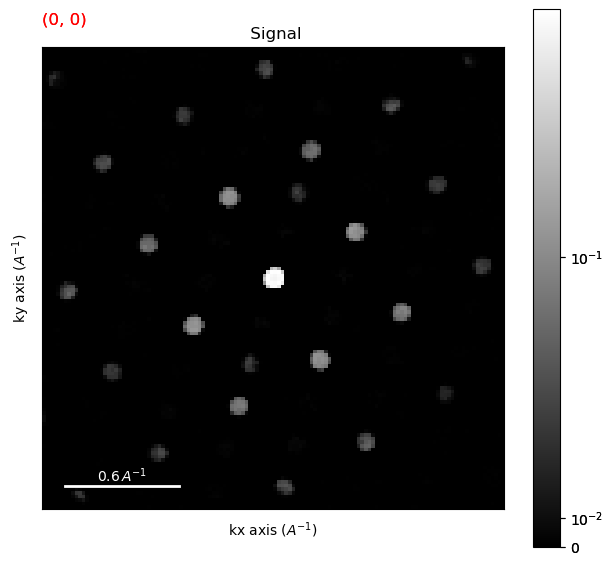

In [11]:
data_clean = s.subtract_diffraction_background('difference of gaussians',
                                                        min_sigma=2, # These can be difficult to determine, play around with it
                                                        max_sigma=2.2,
                                                        lazy_result=False)
data_clean.data *= 1 / data_clean.data.max() # Normalize dataset again after this
data_clean.plot(norm='symlog')

# Finally we can apply the mask to the dataset

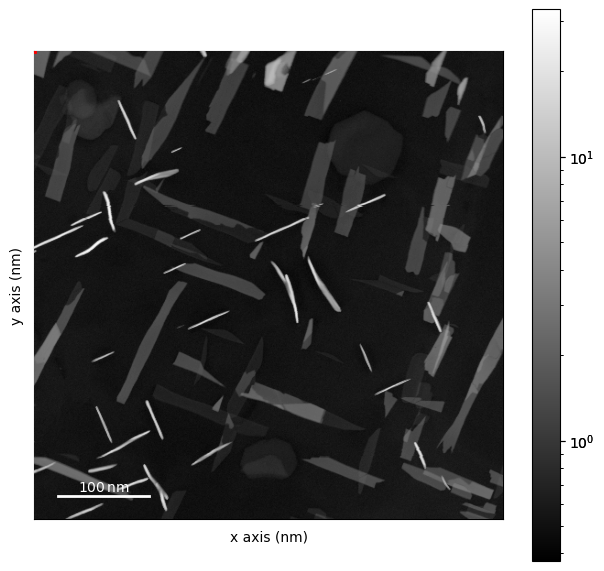

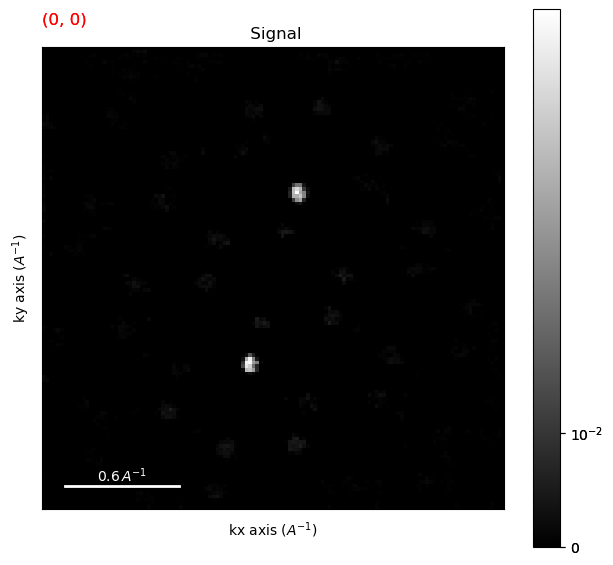

In [12]:
masked_data = data_clean*tot_mask
masked_data.plot(navigator_kwds=dict(norm='log'), norm='symlog') # The navigator view can bbe edited in these plots by adding navigator_kwds=dict(...)

# Saving the mask and the processed dataset

In [13]:
#tot_mask.save('Almask.hdf5')
masked_data.save('SPED_600x600x12_10x10_4p63x4p63_1deg_100Hz_CL12cm_NBD_alpha5_spot1p3_preprocessed_DoG.hdf5')

Overwrite '/media/torit/LaCie/Template/SPED-phase-mapping/TemplateMatching/SPED_600x600x12_10x10_4p63x4p63_1deg_100Hz_CL12cm_NBD_alpha5_spot1p3_preprocessed_DoG.hdf5' (y/n)?
y
